# Analysis of snRNA-seq MDD data

Our hypotheses is that there are statistically significant differences in the gene expression in PV interneurons in males and females.

_install necessary packages (not required on Google Colab, as they are preinstalled there)_

# Setup

In [ ]:
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy
!pip install --quiet pacmap
!pip install --quiet leidenalg
!pip install --quiet sinfo
# snRNA-seq analysis
!pip install --quiet scanpy
!pip install --quiet omnipath
!pip install --quiet decoupler

In [1]:
!git clone https://github.com/EugOT/CN-pr-MDD-snRNA-seq.git
# !git lfs pull # this is propably not necessary on Google Colab
%cd ./CN-pr-MDD-snRNA-seq/

Cloning into 'CN-pr-MDD-snRNA-seq'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 41 (delta 10), reused 11 (delta 4), pack-reused 21
Receiving objects: 100% (41/41), 108.92 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Filtering content: 100% (6/6), 391.61 MiB | 43.04 MiB/s, done.
/content/CN-pr-MDD-snRNA-seq


In [2]:
import os
import random
import pacmap
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import decoupler as dc

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from anndata.experimental.multi_files import AnnCollection


matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = ["Helvetica"]
matplotlib.rcParams["figure.max_open_warning"] = 20000

reseed = 42
random.seed(reseed)
np.random.seed(reseed)

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.figdir = PLOTS_DIR
sc.settings.set_figure_params(
    dpi=180, dpi_save=600, vector_friendly=True, format="pdf", transparent=True
)
sc.settings.autoshow = True
sc.settings.autosave = False

ModuleNotFoundError: ignored

# Load data

In [ ]:
samples_males = pd.read_csv("data/PRJNA602867.tsv", delimiter="\t")
samples_males = samples_males[["Run", "Condition", "LibraryName", "BioProject", "Sex", "NTotalCells"]]

samples_females = pd.read_csv("data/PRJNA883411.tsv", delimiter="\t")
samples_females = samples_females[["Run", "Condition", "LibraryName", "BioProject", "Sex", "NTotalCells"]]

samples_females

,Run,Condition,LibraryName,BioProject,Sex,NTotalCells
0,SRR21678773,1,mdd,PRJNA883411,female,1602
1,SRR21678785,0,control,PRJNA883411,female,1365
2,SRR21678788,1,mdd,PRJNA883411,female,2237
3,SRR21678791,1,mdd,PRJNA883411,female,831
4,SRR21678795,0,control,PRJNA883411,female,1109
5,SRR21678807,1,mdd,PRJNA883411,female,2007
6,SRR21678808,1,mdd,PRJNA883411,female,2296
7,SRR21678809,0,control,PRJNA883411,female,2245
8,SRR21678810,1,mdd,PRJNA883411,female,3724
9,SRR21678774,1,mdd,PRJNA883411,female,2276


_load sequencing samples_

In [ ]:
males = sc.read_h5ad(
    "data/PRJNA602867-whole_dataset-fpr_0.001-clusters.h5ad"
)
males.obs['Run'] = males.obs['orig.ident']
males.obs = pd.merge(samples_males, males.obs, on="Run").set_index("cell_name", drop=False)
males.uns["name"] = "PRJNA602867"
sc.pp.filter_cells(males, min_genes=500)
sc.pp.filter_genes(males, min_cells=10)

females = sc.read_h5ad(
    "data/PRJNA883411-whole_dataset-fpr_0.001-clusters.h5ad"
)
females.obs['Run'] = females.obs['orig.ident']
females.obs = pd.merge(females.obs, samples_females, on="Run", how = "inner").set_index("cell_name", drop=False)
females.uns["name"] = "PRJNA883411"
sc.pp.filter_cells(females, min_genes=500)
sc.pp.filter_genes(females, min_cells=10)

In [ ]:
males.obs = males.obs[[
    'cell_name',
    'background_fraction',
    'droplet_efficiency',
    'doublet_score',
    'nFeature_Diff',
    'nCount_Diff',
    'percent_mito',
    'percent_ribo',
    'percent_mito_ribo',
    'percent_hb',
    'log10GenesPerUMI',
    'k_tree',
    'Run',
    'Condition',
    'BioProject',
    'Sex',
    'n_genes']]

females.obs = females.obs[[
    'cell_name',
    'background_fraction',
    'droplet_efficiency',
    'doublet_score',
    'nFeature_Diff',
    'nCount_Diff',
    'percent_mito',
    'percent_ribo',
    'percent_mito_ribo',
    'percent_hb',
    'log10GenesPerUMI',
    'k_tree',
    'Run',
    'Condition',
    'BioProject',
    'Sex',
    'n_genes']]

_determine highly variable genes (HVGs)_

In [ ]:
sc.experimental.pp.highly_variable_genes(males, flavor="pearson_residuals", n_top_genes=5000)
sc.experimental.pp.highly_variable_genes(females, flavor="pearson_residuals", n_top_genes=5000)
males = males[:, males.var["highly_variable"]]
females = females[:, females.var["highly_variable"]]
males.obs["k_tree"] = males.obs["Sex"].astype(str) + "_" + males.obs["k_tree"].astype(str)
females.obs["k_tree"] = females.obs["Sex"].astype(str) + "_" + females.obs["k_tree"].astype(str)

/tmp/ipykernel_30558/3283660448.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  males.obs["k_tree"] = males.obs["Sex"].astype(str) + "_" + males.obs["k_tree"].astype(str)
/tmp/ipykernel_30558/3283660448.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  females.obs["k_tree"] = females.obs["Sex"].astype(str) + "_" + females.obs["k_tree"].astype(str)


In [ ]:
adata = ad.concat([males, females], join="inner")
#keep raw and depth-normalized counts for later
adata.layers["raw"] = adata.X.copy()
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])
adata.raw = adata
sc.experimental.pp.recipe_pearson_residuals(adata, n_top_genes=2000, batch_key="Run")

_perform PCA, compute the neighborhood graph and clustering_

In [ ]:
embedding = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, apply_pca=False
)
adata.obsm["X_pacmap"] = embedding.fit_transform(adata.obsm["X_pca"], init="pca")
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50, method='umap')
sc.tl.umap(adata, method='umap')
sc.tl.leiden(adata)

/home/alex/.local/lib/python3.10/site-packages/pacmap/pacmap.py:838: UserWarning: Running ANNOY Indexing on high-dimensional data. Nearest-neighbor search may be slow!
  warnings.warn(


_rank HVGs per cluster_

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', key_added="leiden")

/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**define marker genes**  
We are primarily interested in Pvalb cells which are the PV interneurons.  
Pvalb is short for `Pvalb+ GABAergic neuron` and PV interneuron means `Parvalbumin-expressing interneurons`.  
These sources suggest that we can treat these as the same: https://pubmed.ncbi.nlm.nih.gov/32949644/, https://www.nature.com/articles/s41467-020-20328-4

In [ ]:
# Define the table as a multiline string
table = """
Label	Expanded Label	OBO Ontology ID	Markers
Astro	Astrocyte	astrocyte	SLC1A2, ADGRV1, SLC1A3, GPC5, RNF219-AS1, ARHGAP24, CST3, HPSE2, AQP4, COL5A3
Endo	Endothelial cell	endothelial cell	EBF1, ABCG2, CLDN5, FLI1, LEF1, EMCN, IFI27, HLA-E, ADGRL4, CLEC3B
L2/3 IT	Layer 2-3 glutamatergic neuron, intratelencephalon-projecting	glutamatergic neuron	CBLN2, EPHA6, LAMA2, CNTN5, PDZD2, CUX2, RASGRF2, LINC01378, CA10
L5 ET	Layer 5 glutamatergic neuron, extratelencephalon-projecting	glutamatergic neuron	COL5A2, VAT1L, COL24A1, CBLN2, NRP1, PTCHD1.AS, NRG1, HOMER1, SLC35F3
L5 IT	Layer 5 glutamatergic neuron, intratelencephalon-projecting	glutamatergic neuron	FSTL4, CNTN5, RORB, FSTL5, IL1RAPL2, CHN2, TOX, CPNE4, CADPS2, POU6F2
L5/6 NP	Layer 5-6 glutamatergic neuron, near-projecting	glutamatergic neuron	TSHZ2, NPSR1-AS1, HTR2C, ITGA8, ZNF385D, ASIC2, CDH6, CRYM, NXPH2, CPNE4
L6 CT	Layer 6 glutamatergic neuron, corticothalamic-projecting	glutamatergic neuron	ADAMTSL1, KIAA1217, SORCS1, HS3ST4, TRPM3, TOX, SEMA3E, EGFEM1P, MEIS2, SEMA5A
L6 IT	Layer 6 glutamatergic neuron, intratelencephalon-projecting	glutamatergic neuron	PTPRK, PDZRN4, CDH9, THEMIS, FSTL5, CDH13, CDH12, CBLN2, LY86-AS1, MLIP
L6 IT Car3	Layer 6 Car3+ glutamatergic neuron, intratelencephalon-projecting	glutamatergic neuron	THEMIS, RNF152, NTNG2, STK32B, KCNMB2, GAS2L3, OLFML2B, POSTN, B3GAT2, NR4A2
L6b	Layer 6b glutamatergic neuron	glutamatergic neuron	HS3ST4, KCNMB2, MDFIC, C10orf11, NTM, CDH9, MARCH1, TLE4, FOXP2, KIAA1217
Lamp5	Lamp5+ GABAergic neuron	GABAergic neuron	FGF13, PTPRT, PRELID2, GRIA4, RELN, PTCHD4, EYA4, MYO16, FBXL7, LAMP5
Micro-PVM	microglia / perivascular macrophage	perivascular macrophage	DOCK8, P2RY12, APBB1IP, FYB, PTPRC, TBXAS1, CX3CR1, BLNK, SLCO2B1, CSF1R
Oligo	oligodendrocyte	oligodendrocyte	PLP1, ST18, CTNNA3, MBP, MOBP, RNF220, NCKAP5, ENPP2, QKI, SLC44A1
OPC	oligodendrocyte precursor cell	oligodendrocyte precursor cell	VCAN, PDGFRA, OLIG1, SMOC1, COL9A1, STK32A, BCAS1, FERMT1, BCHE, ZCCHC24
Pvalb	Pvalb+ GABAergic neuron	GABAergic neuron	ADAMTS17, ERBB4, DPP10, ZNF804A, MYO16, BTBD11, GRIA4, SLIT2, SDK1, PVALB
Sncg	Sncg+ GABAergic neuron	GABAergic neuron	CNR1, SLC8A1, ASIC2, CXCL14, MAML3, ADARB2, NPAS3, CNTN5, FSTL5, SNCG
Sst	Sst+ GABAergic neuron	GABAergic neuron	GRIK1, RALYL, SST, TRHDE, GRID2, NXPH1, COL25A1, SLC8A1, SOX6, ST6GALNAC5
Sst Chodl	Sst+ Chodl+ GABAergic neuron	GABAergic neuron	NPY, STAC, OTOF, NPY2R, CRHBP, ANKRD34B, NOS1, SST, CHODL
Vip	Vip+ GABAergic neuron	GABAergic neuron	GALNTL6, LRP1B, VIP, GRM7, KCNT2, THSD7A, ERBB4, SYNPR, ADARB2, SLC24A3
VLMC	vascular lepotomeningeal cell	brain pericyte	COLEC12, ITIH5, COL1A2, TBX18, EBF1, C7, COL6A2, SRPX2, FLVCR2, FMO2
"""

# Split the table into lines
lines = table.strip().split('\n')

# Initialize an empty dictionary
labels_markers_dict = {}

# Process each line
for line in lines[1:]:  # Skip the header
    # Split the line into fields
    fields = line.split('\t')
    # The label is the first field
    label = fields[0]
    # The markers is the fourth field, split into a list and take the first three
    markers = fields[3].split(', ')[:3]
    # Add to the dictionary
    labels_markers_dict[label] = markers

markers_df = pd.DataFrame(columns=["genesymbol", "celltype"])

for celltype, markers in labels_markers_dict.items():
    for marker in markers:
        markers_df.loc[len(markers_df.index)] = [marker, celltype]

markers_df[markers_df["celltype"] == "Pvalb"]

,genesymbol,celltype
42,ADAMTS17,Pvalb
43,ERBB4,Pvalb
44,DPP10,Pvalb


_determine overlap between HVGs in clusters and marker genes_

In [ ]:
# Enrichment with Over Representation Analysis
dc.run_ora(
    mat=adata,
    net=markers_df,
    source="celltype",
    target="genesymbol",
    min_n=3,
    verbose=False,
    use_raw=True,
)

# Object for visualizing the ORA-results
acts = dc.get_acts(adata, obsm_key="ora_estimate")
acts

/home/alex/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 75628 × 18
    obs: 'cell_name', 'background_fraction', 'droplet_efficiency', 'doublet_score', 'nFeature_Diff', 'nCount_Diff', 'percent_mito', 'percent_ribo', 'percent_mito_ribo', 'percent_hb', 'log10GenesPerUMI', 'k_tree', 'Run', 'Condition', 'BioProject', 'Sex', 'n_genes', 'leiden'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pacmap', 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

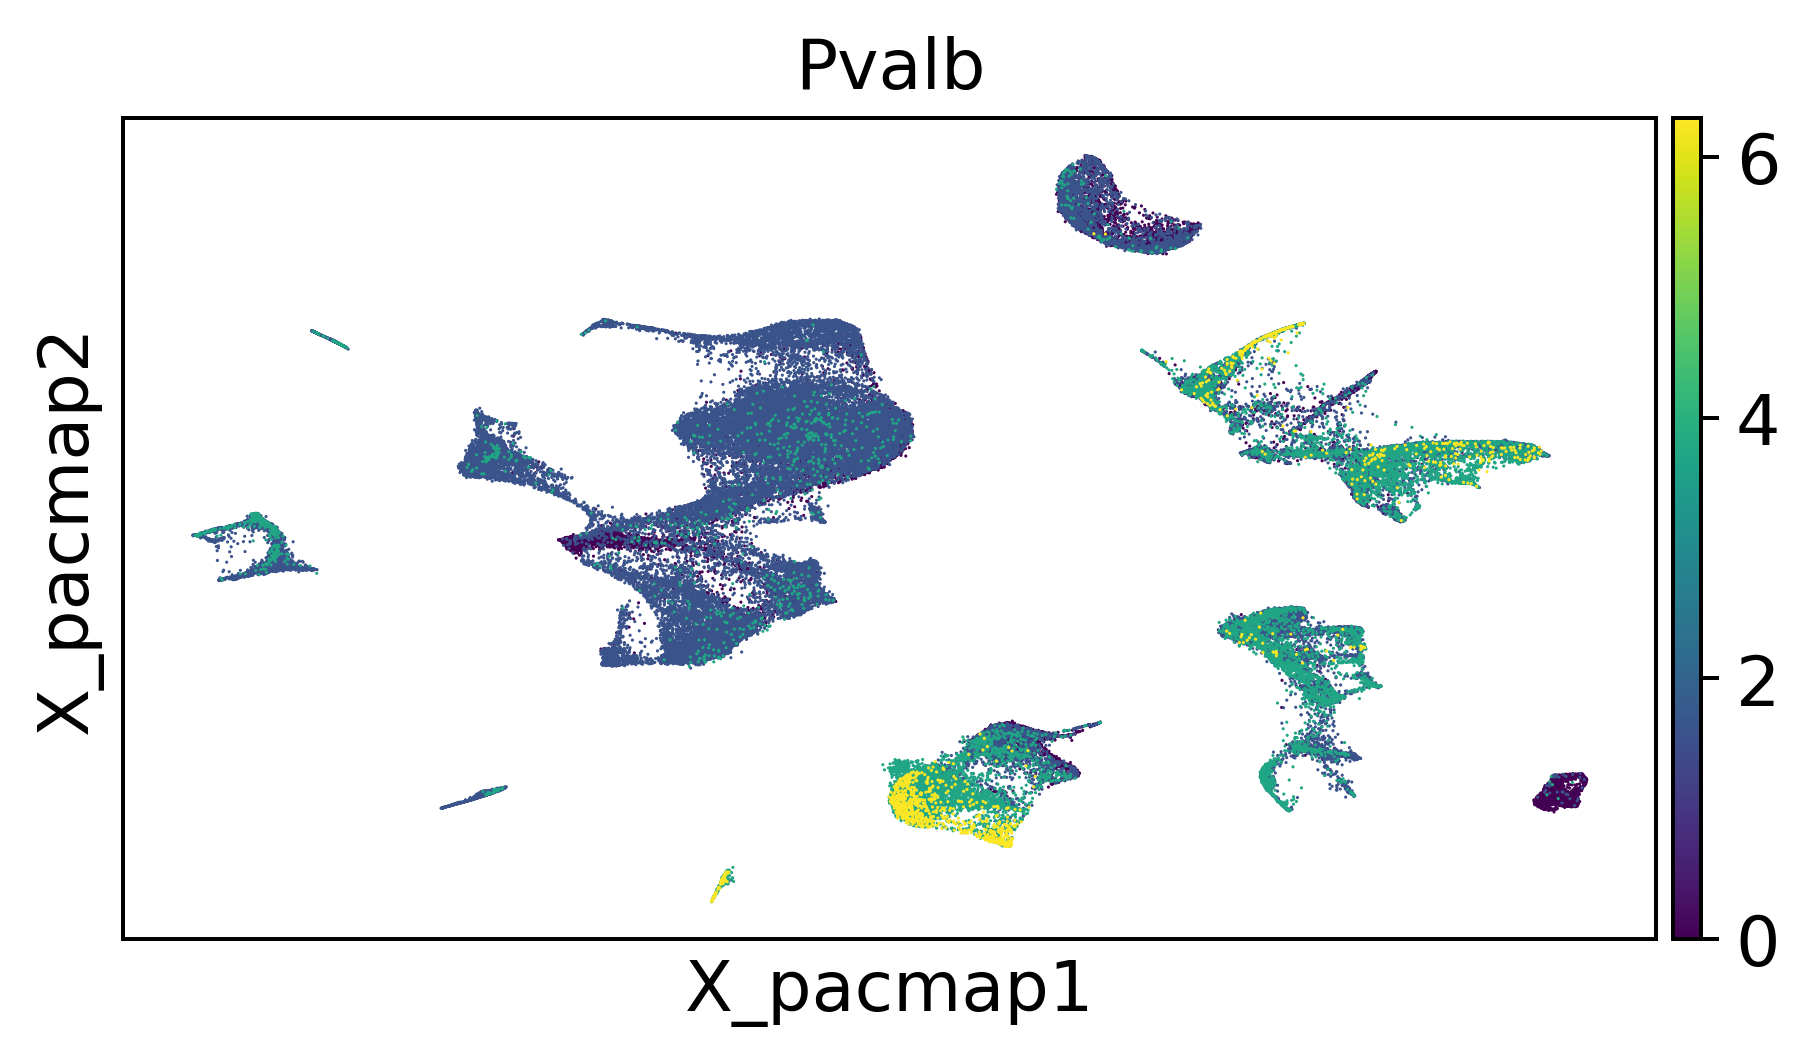

In [ ]:
with rc_context({'figure.figsize': (6, 3)}):
    sc.pl.embedding(
        acts,
        basis="X_pacmap",
        color=["Pvalb"],
        ncols=4
    )

_annotate clusters with their celltypes_

In [ ]:
mean_enr = dc.summarize_acts(acts, groupby="leiden", min_std=1)
annotation_dict = dc.assign_groups(mean_enr)
# Add cell type column based on annotation
adata.obs["ora_celltype"] = [
    annotation_dict[str(clust)] for clust in adata.obs["leiden"]
]
annotation_dict

{'0': 'L5 IT',
 '1': 'L5 IT',
 '10': 'L5 IT',
 '11': 'Oligo',
 '12': 'L5 IT',
 '13': 'Astro',
 '14': 'L5 IT',
 '15': 'L5 IT',
 '16': 'Oligo',
 '17': 'L5 IT',
 '18': 'L5 IT',
 '19': 'Astro',
 '2': 'L5 IT',
 '20': 'Astro',
 '21': 'L5 IT',
 '22': 'L5 IT',
 '23': 'Astro',
 '24': 'Oligo',
 '25': 'L5 IT',
 '26': 'Astro',
 '27': 'L5 IT',
 '28': 'L5 IT',
 '29': 'Astro',
 '3': 'L5 IT',
 '30': 'Oligo',
 '31': 'L5 IT',
 '32': 'L5 IT',
 '33': 'L5 IT',
 '34': 'Astro',
 '35': 'Oligo',
 '36': 'Oligo',
 '37': 'L5 IT',
 '38': 'L5 IT',
 '4': 'Astro',
 '5': 'L5 IT',
 '6': 'L5 IT',
 '7': 'L5 IT',
 '8': 'L5 IT',
 '9': 'L5 IT'}

## ^ none of the clusters is annotated as Pvalb?

In [ ]:
adata.obs["sex_ora_celltype"] = pd.Categorical(adata.obs["Sex"].astype(str) + "_" + adata.obs["ora_celltype"].astype(str))
sc.tl.rank_genes_groups(adata, 'sex_ora_celltype', method='logreg', key_added="sex_ora_celltype")

/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/home/alex/.local/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/alex/.local/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
/home/alex/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alex

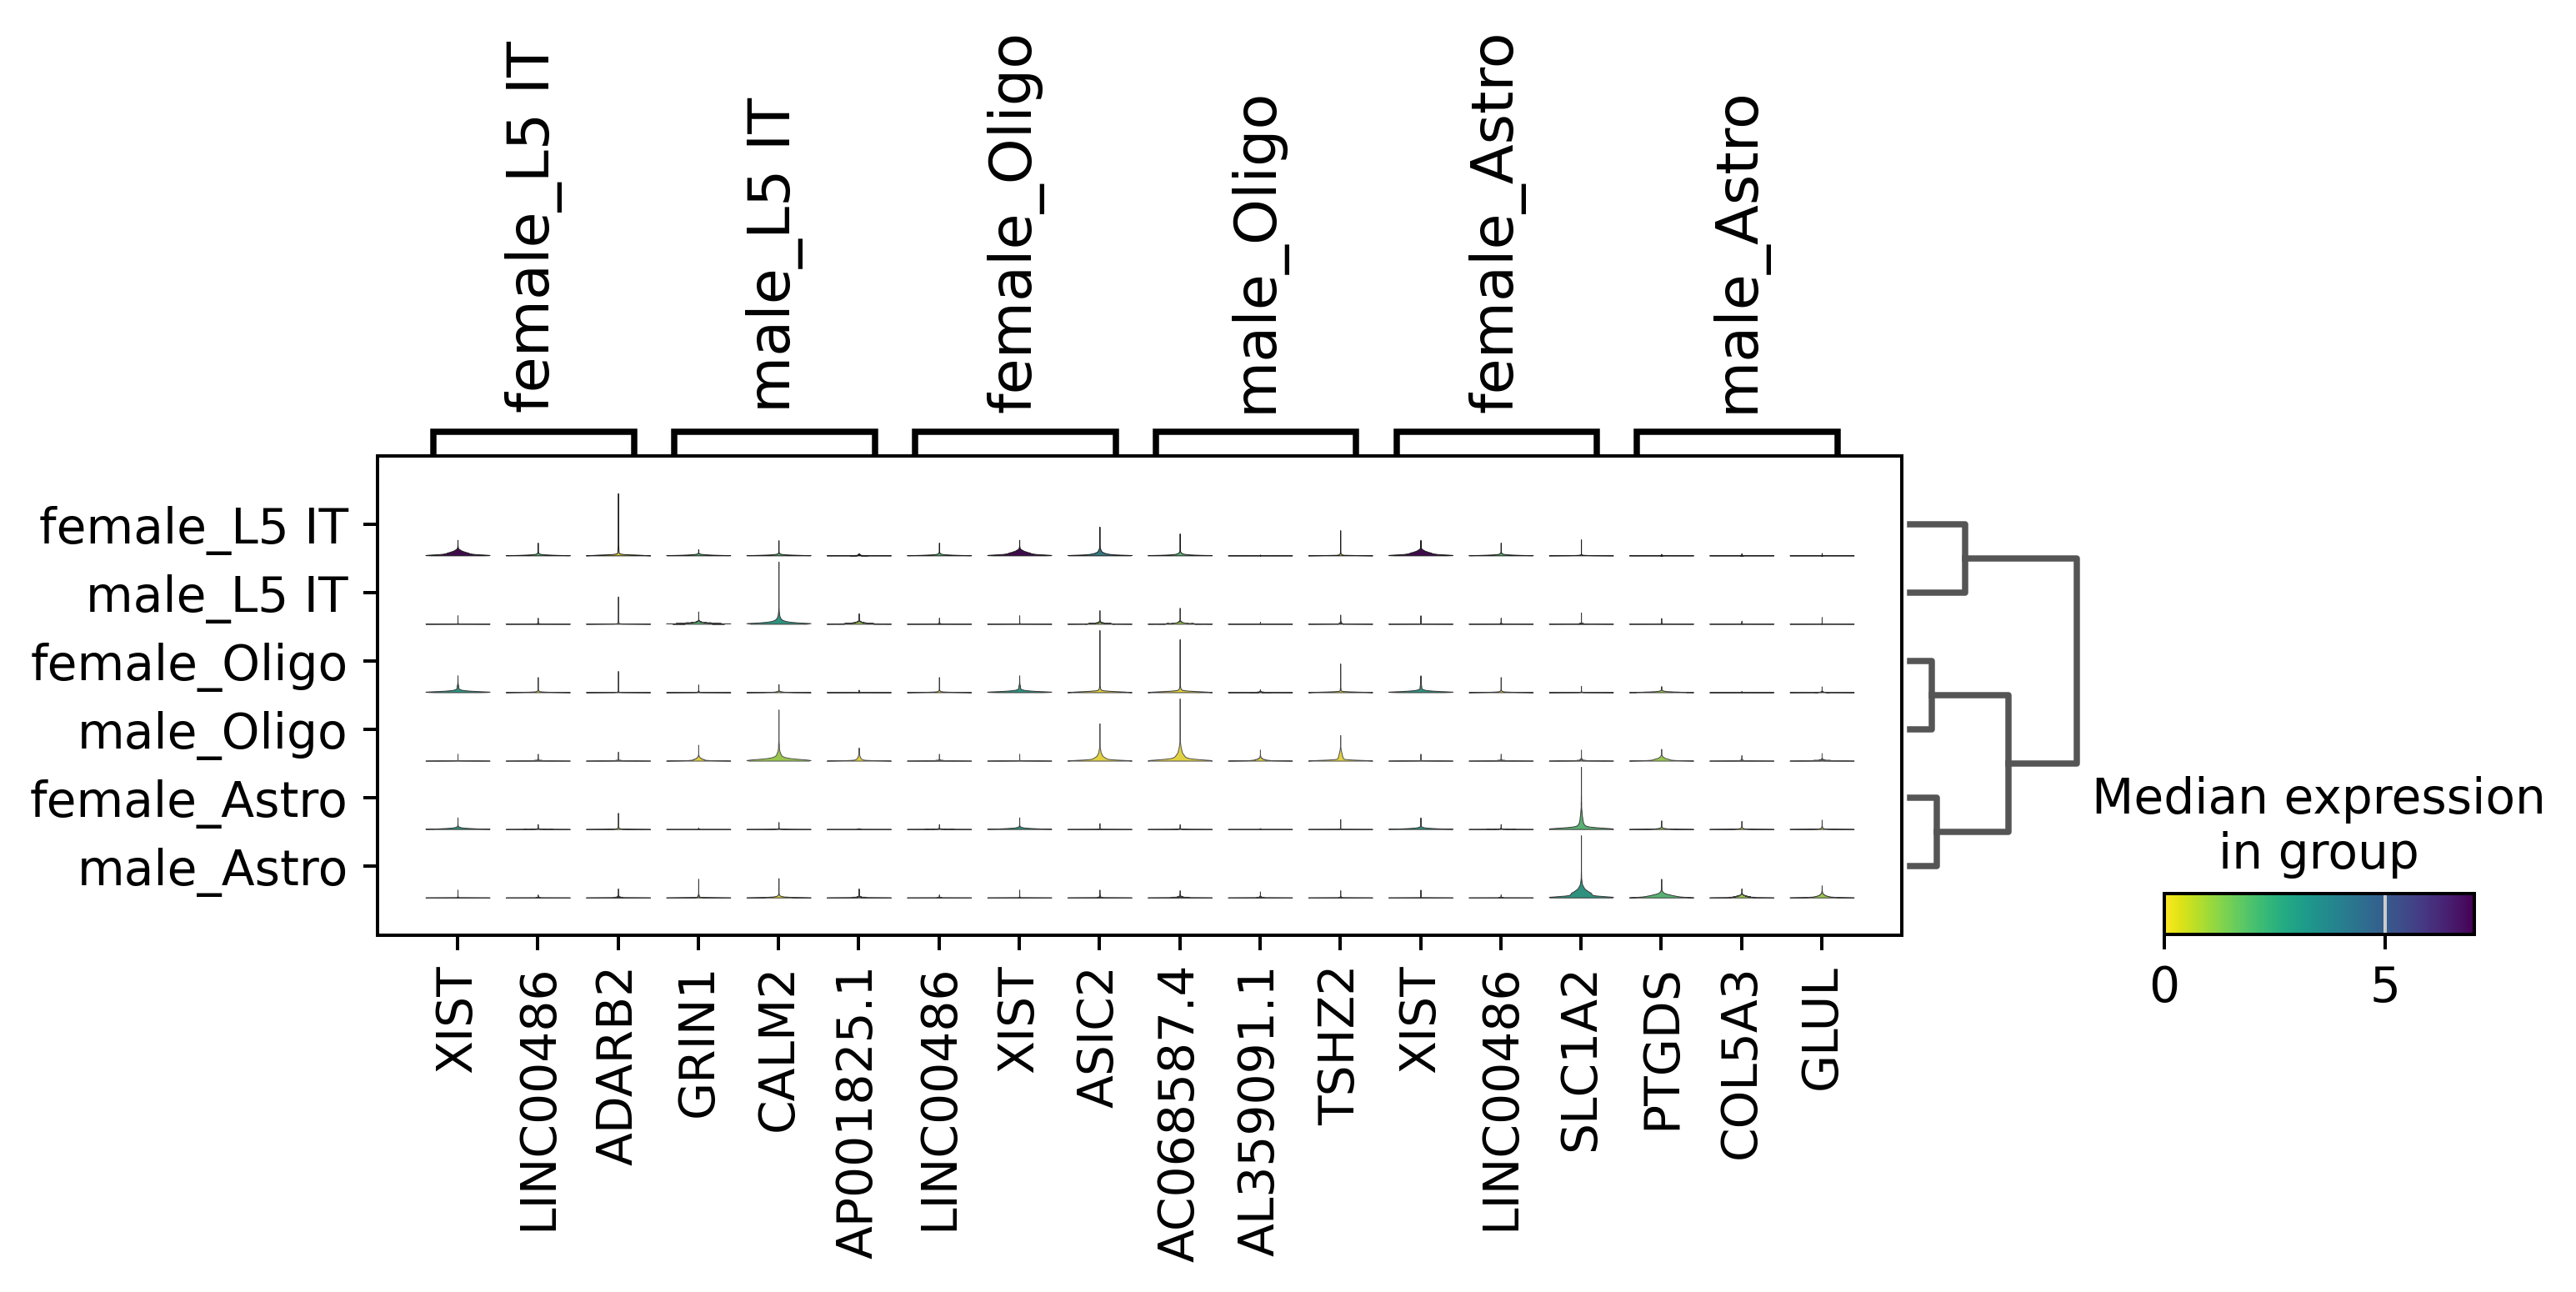

In [ ]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=3, cmap='viridis_r', key='sex_ora_celltype')

/home/alex/.local/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/alex/.local/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


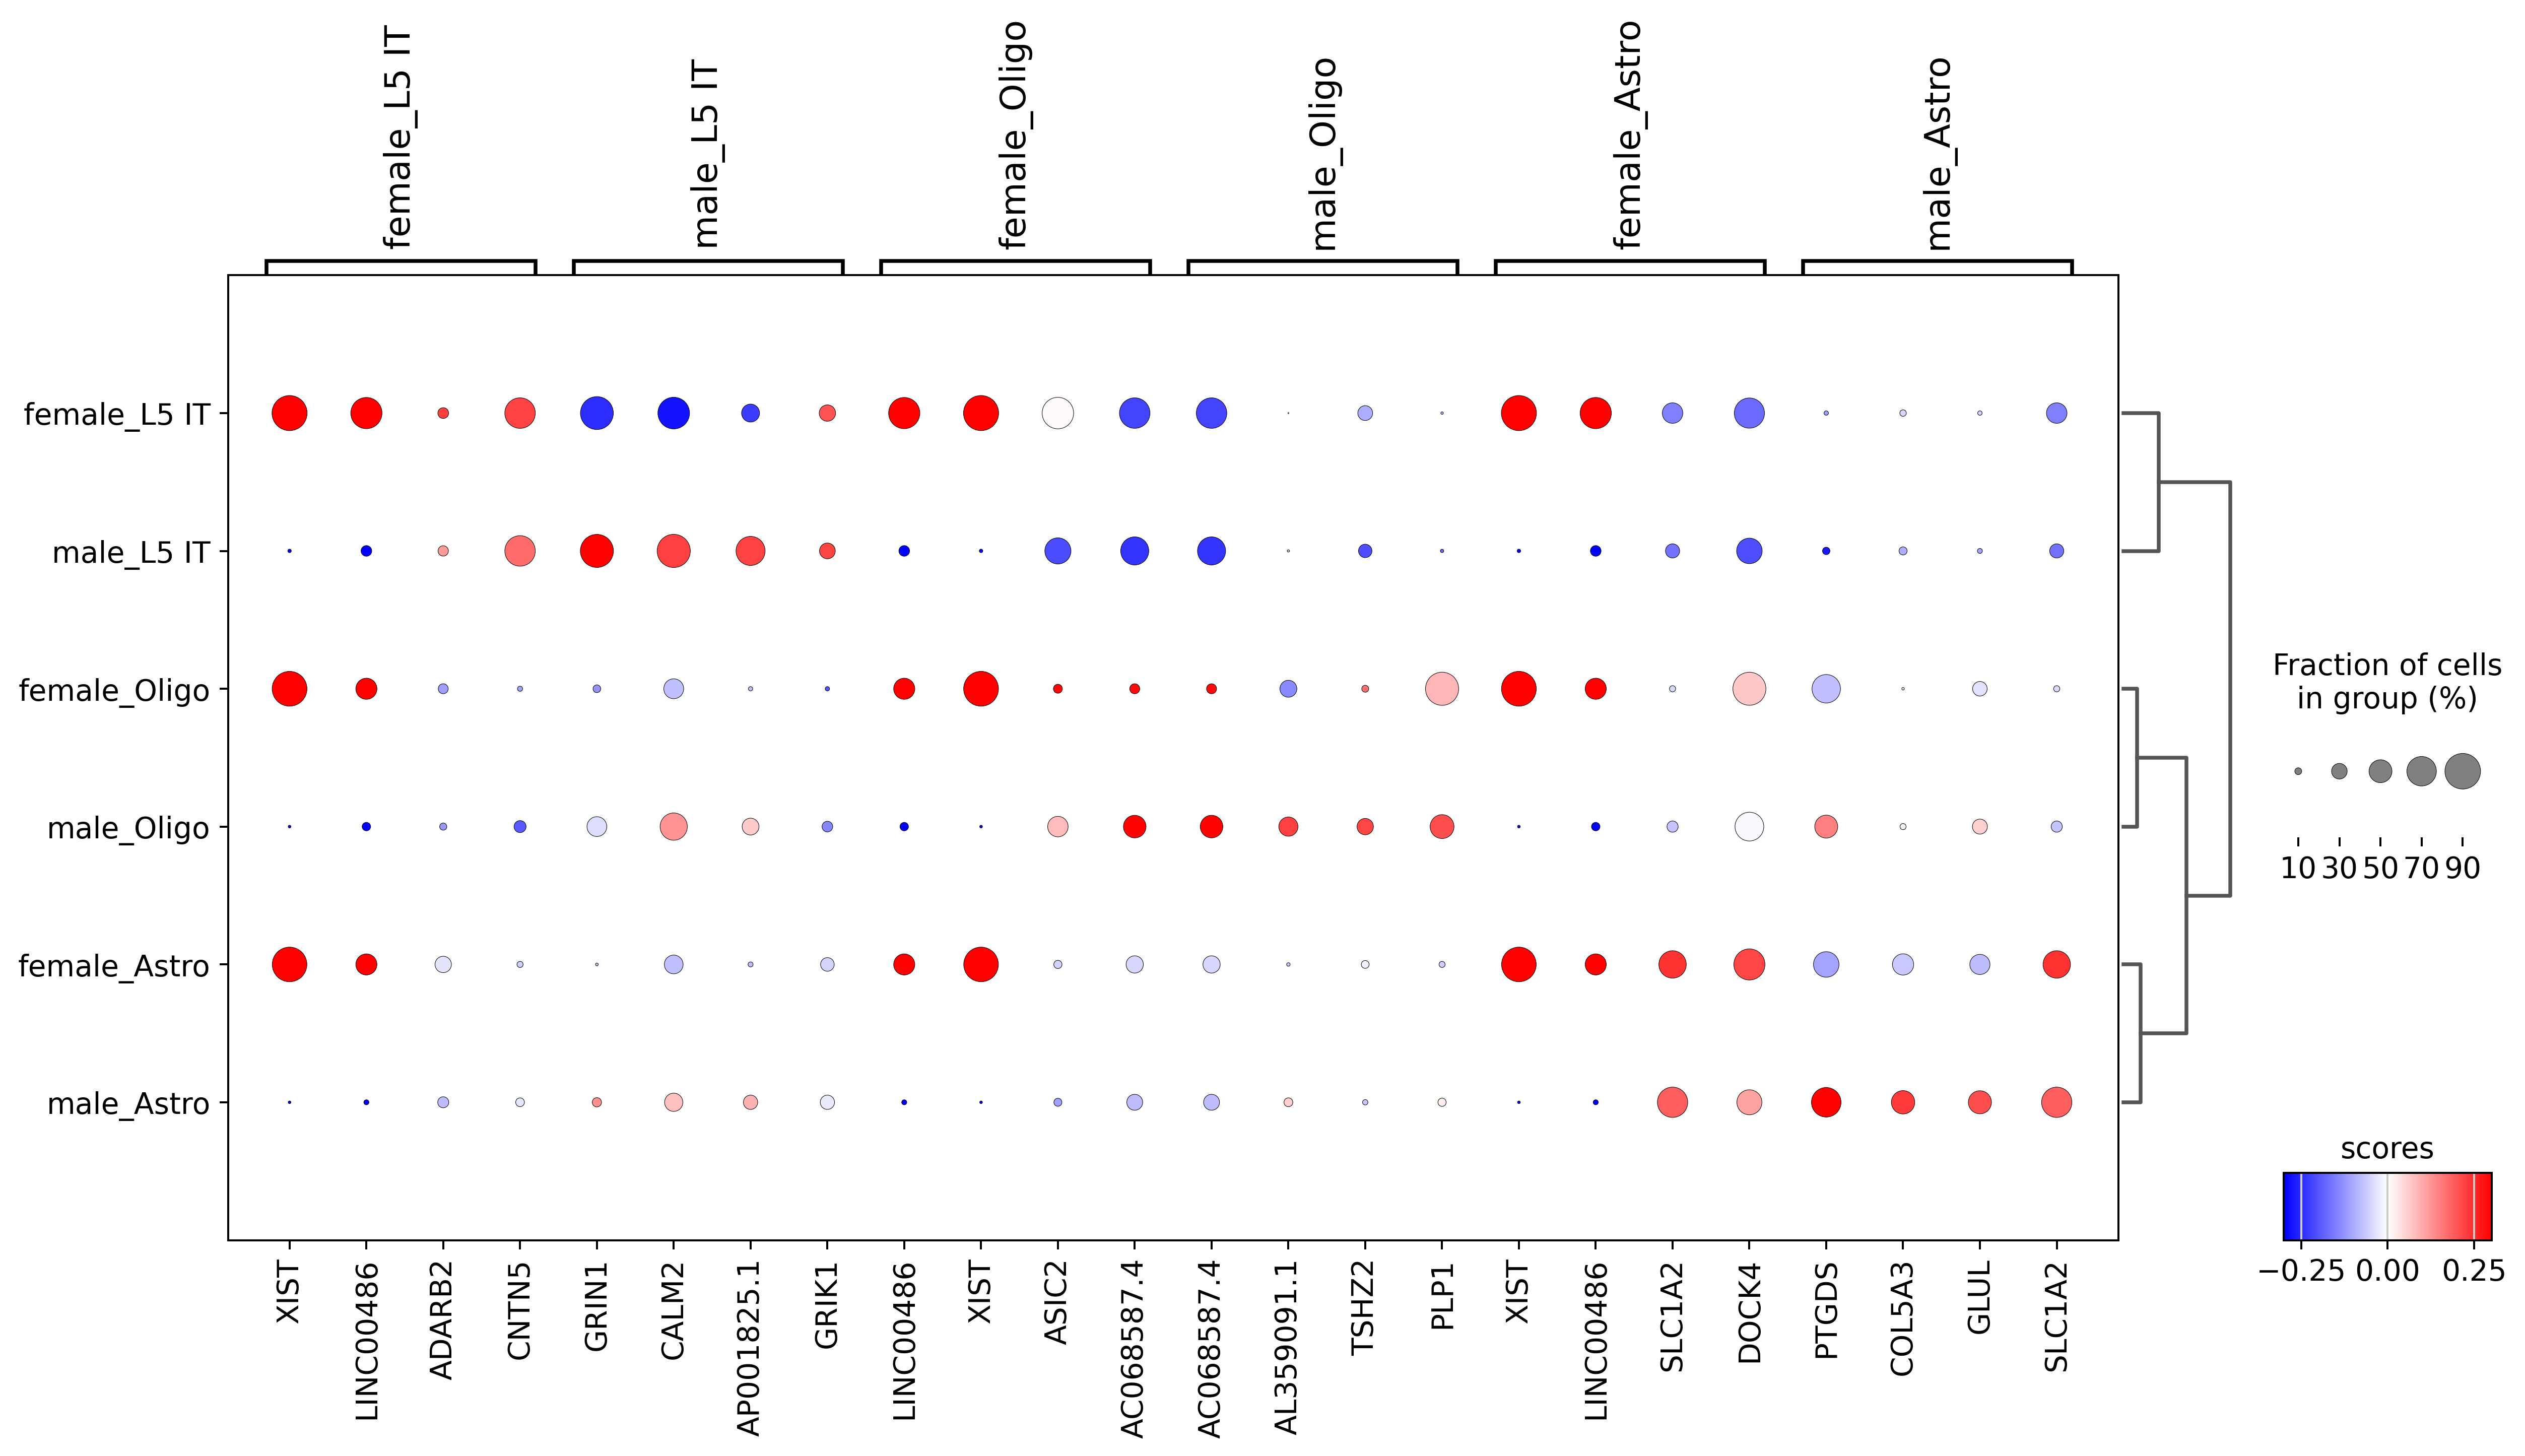

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot='scores', vmax=0.3, vmin=-0.3, cmap='bwr', key='sex_ora_celltype', figsize=(16,7))

In [ ]:
from sinfo import sinfo

sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.10.3
decoupler   1.5.0
matplotlib  3.8.1
numpy       1.26.2
pacmap      0.7.1
pandas      2.1.3
scanpy      1.9.6
sinfo       0.3.4
-----
IPython             8.17.2
jupyter_client      8.6.0
jupyter_core        5.5.0
jupyterlab          4.0.8
notebook            7.0.6
-----
Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Linux-6.2.0-37-generic-x86_64-with-glibc2.35
8 logical CPU cores, x86_64
-----
Session information updated at 2023-11-29 23:07
